In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

'1.12.0'

In [2]:
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit

iris = datasets.load_iris()
type(iris["feature_names"])

list

In [3]:
features = pd.DataFrame(iris["data"])
target = pd.Series(iris["target"])
flower_names = iris["target_names"]
feature_names = iris["feature_names"]

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, target):
    X_train = features.loc[train_index]
    y_train = target.loc[train_index]
    X_test = features.loc[test_index]
    y_test = target.loc[test_index]

In [4]:
# y_train.hist() # Just to confirm the stratification
features.head()
X_train.describe()

,0,1,2,3
count,120.000000,120.000000,120.00000,120.000000
mean,5.841667,3.048333,3.77000,1.205000
std,0.840926,0.448524,1.76852,0.762663
min,4.300000,2.000000,1.10000,0.100000
25%,5.100000,2.800000,1.60000,0.300000
50%,5.750000,3.000000,4.25000,1.300000
75%,6.400000,3.325000,5.10000,1.800000
max,7.900000,4.400000,6.90000,2.500000


In [17]:
features[4]=features[1]
features.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,3.5
1,4.9,3.0,1.4,0.2,3.0
2,4.7,3.2,1.3,0.2,3.2
3,4.6,3.1,1.5,0.2,3.1
4,5.0,3.6,1.4,0.2,3.6


We will use One-Hot encoding for our labels as it makes it more reasonable to pass into a neural network model

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
y_test_1hot = enc.fit_transform([[label] for label in y_test])

y_train_1hot[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## Constructing the model

We'll try building a Keras neural network for this data set

In [6]:
import keras

keras.backend.clear_session()

nn = keras.models.Sequential()

Dense = keras.layers.Dense

nn.add(Dense(units = 16, activation="relu", input_dim=4))
# nn.add(tf.keras.layers.Dropout(0.1))
nn.add(Dense(units = 16, activation="relu"))
# nn.add(tf.keras.layers.Dropout(0.2))
# nn.add(Dense(units = 16, activation="relu"))
nn.add(Dense(units=3, activation='softmax'))
# nn.add(Dense(units=3))

nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


## Training

In [7]:
nn.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [8]:
tb_callback = keras.callbacks.TensorBoard(log_dir=root_logdir, histogram_freq=0, batch_size=32,
                                             write_graph=True, write_grads=False, write_images=False,
                                             embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
                                             embeddings_data=None)

history = nn.fit(X_train.values, y_train_1hot, epochs=10, batch_size = 20, callbacks=[tb_callback])

Epoch 1/10
120/120 [==============================] - 0s 652us/step - loss: 1.1510 - acc: 0.3333
Epoch 2/10
120/120 [==============================] - 0s 43us/step - loss: 0.9990 - acc: 0.3333
Epoch 3/10
120/120 [==============================] - 0s 54us/step - loss: 0.9300 - acc: 0.3333
Epoch 4/10
120/120 [==============================] - 0s 52us/step - loss: 0.8844 - acc: 0.6417
Epoch 5/10
120/120 [==============================] - 0s 48us/step - loss: 0.8513 - acc: 0.8750
Epoch 6/10
120/120 [==============================] - 0s 45us/step - loss: 0.8332 - acc: 0.8500
Epoch 7/10
120/120 [==============================] - 0s 51us/step - loss: 0.8153 - acc: 0.9083
Epoch 8/10
120/120 [==============================] - 0s 63us/step - loss: 0.7973 - acc: 0.8583
Epoch 9/10
120/120 [==============================] - 0s 45us/step - loss: 0.7797 - acc: 0.8583
Epoch 10/10
120/120 [==============================] - 0s 62us/step - loss: 0.7627 - acc: 0.8750


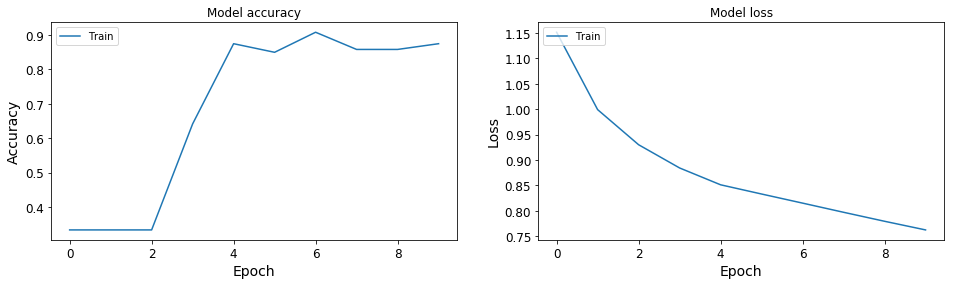

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))

# Plot training & validation accuracy values
axs[0].plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
loss_and_metrics = nn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

30/30 [==============================] - 0s 827us/step
Scores on test set: loss=0.149 accuracy=1.0000


## LRP

Now we try using LRP to generate relevances

In [22]:

import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
    print(header)
    
    for rel,pred,actual in zip(analysis,prediction, labels):
        result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), actual)
        print(result)
    df_anal = pd.DataFrame(analysis)
    print()
#     print(df_anal.describe())
    return df_anal

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(nn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)

flowers=X_test.values
types=y_test.values

# perform_analysis(nn,gradient_analyzer,flowers,types)
lrp_results = perform_analysis(nn,lrp,flowers,types)

          Relevances           Pred Actual
[ 2.9993  5.32   -2.6544 -0.2467] 0 0
[-8.3307 -3.5668 10.5158  3.1784] 2 2
[ 3.0942 -0.1102 -1.0574 -0.4929] 1 1
[ 3.1574 -0.1056 -1.0574 -0.4929] 1 1
[ 4.1046  3.8124 -1.9288 -0.2307] 0 0
[ 5.4798  2.2207 -5.0478 -1.4338] 1 1
[ 4.2911  4.289  -1.4837 -0.2307] 0 0
[ 3.6809  6.0293 -3.4711 -0.2467] 0 0
[-8.877  -3.5668 11.1596  3.5315] 2 2
[ 4.6969  2.0188 -4.833  -1.3442] 1 1
[-9.9696 -3.4479 13.5203  3.1784] 2 2
[-9.4233 -3.6857 10.945   4.0612] 2 2
[-1.4993 -0.8643  4.3214  1.5372] 2 2
[ 5.5667  2.1534 -4.833  -1.3442] 1 1
[ 3.4083  6.0293 -3.0627 -0.2467] 0 0
[ 3.4083  5.852  -2.8585 -0.2467] 0 0
[ 5.4106  4.7655 -1.7804 -0.2307] 0 0
[ 4.1572  1.3178 -3.2409 -0.8104] 1 1
[ 5.3058  1.9515 -5.0478 -1.2546] 1 1
[-8.1942 -3.5668 10.3012  3.1784] 2 2
[ 3.7543  6.0131 -2.643  -0.1991] 0 0
[-9.1501 -3.6857 12.0181  4.2378] 2 2
[ 5.7407  1.9515 -4.9404 -1.165 ] 1 1
[-8.0439 -2.7777 11.1171  2.7384] 2 2
[-1.4762 -0.8067  4.1724  1.5372] 2 2
[ 5.827

          Relevances           Pred Actual
[ 2.9993  5.32   -2.6544 -0.2467] 0 0
[ 4.1046  3.8124 -1.9288 -0.2307] 0 0
[ 4.2911  4.289  -1.4837 -0.2307] 0 0
[ 3.6809  6.0293 -3.4711 -0.2467] 0 0
[ 3.4083  6.0293 -3.0627 -0.2467] 0 0
[ 3.4083  5.852  -2.8585 -0.2467] 0 0
[ 5.4106  4.7655 -1.7804 -0.2307] 0 0
[ 3.7543  6.0131 -2.643  -0.1991] 0 0
[ 3.8854  6.7386 -3.4711 -0.3701] 0 0
[ 3.5446  6.0293 -2.8585 -0.2467] 0 0

          Relevances           Pred Actual
[ 3.0942 -0.1102 -1.0574 -0.4929] 1 1
[ 3.1574 -0.1056 -1.0574 -0.4929] 1 1
[ 5.4798  2.2207 -5.0478 -1.4338] 1 1
[ 4.6969  2.0188 -4.833  -1.3442] 1 1
[ 5.5667  2.1534 -4.833  -1.3442] 1 1
[ 4.1572  1.3178 -3.2409 -0.8104] 1 1
[ 5.3058  1.9515 -5.0478 -1.2546] 1 1
[ 5.7407  1.9515 -4.9404 -1.165 ] 1 1
[ 5.8277  2.0188 -5.37   -1.5235] 1 1
[ 4.8996  1.5813 -3.6565 -1.0314] 1 1

          Relevances           Pred Actual
[-8.3307 -3.5668 10.5158  3.1784] 2 2
[-8.877  -3.5668 11.1596  3.5315] 2 2
[-9.9696 -3.4479 13.5203  3.1784]

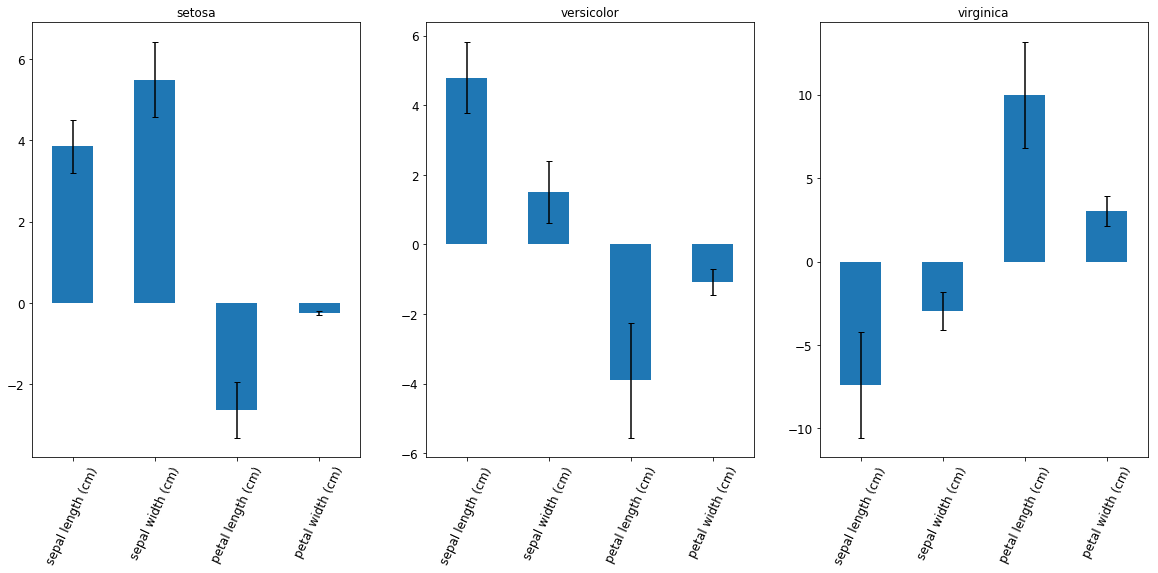

In [23]:
# # Applying the analyzer for all flowers

fig, axs = plt.subplots(1, 3, figsize=(20,8))

for label in range(0,3):
#     label =  # Just looking at first flower type
    label_idxs = (y_test == label)

    flowers = X_test[label_idxs].values
    types = y_test[label_idxs].values
    lrp_results = perform_analysis(nn,lrp,flowers,types)
    
    avgs = lrp_results.mean()
    errs = lrp_results.std()
    
    ax=avgs.plot(kind="bar",ax=axs[label],yerr=errs, capsize=3, title=flower_names[label])
    ax.set_xticklabels(feature_names, rotation=65)

### Negative features can be thought of as discriminating features
If its "confusing" for one class -> it should be important for some other class in a multi class setup
thus should not see this for two classes only

Maybe for brain stuff 
- get top 3 features for one sample patient
- plot other samples using these features as dimensions
    - to see if OTHER samples can cluster around this guy
    - plot relevance or values?
    - do they have a relevance profile?
    
Compute distance from the relevance vector?

Add another feature manually..?

#### Use cross validation
10 fold

Leave one out is over optimistic

do a fold analysis

Run SVM

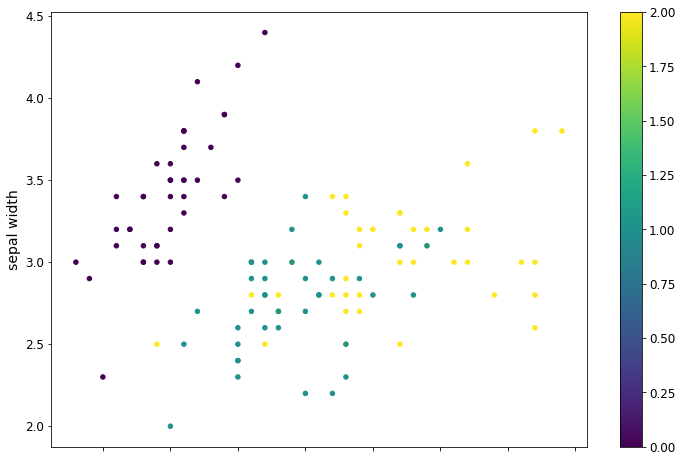

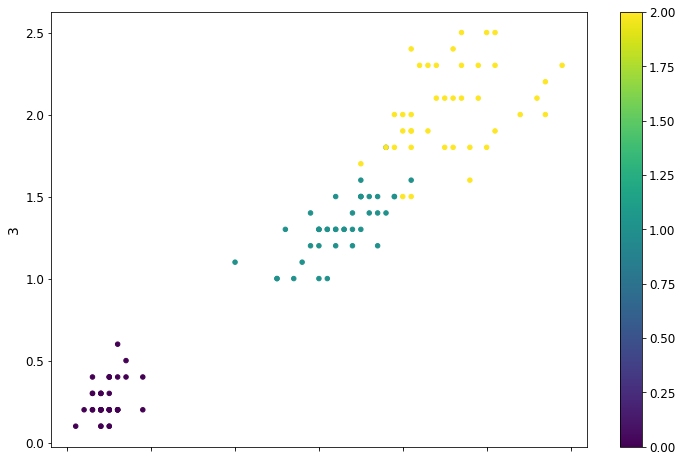

In [14]:
# predictions = nn.predict(X_train)
ax=X_train.plot.scatter(figsize=[12,8],x=0,y=1,c=y_train, colormap="viridis")
ax.set(ylabel="sepal width")
# plt.show()
X_train.plot.scatter(figsize=[12,8],x=2,y=3,c=y_train, colormap="viridis")